# One example: training
### With a single old QCD file

In [2]:
import uproot4 as uproot
import numpy as np
import awkward1 as ak

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep as hep

import coffea.hist as hist

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, ConcatDataset, WeightedRandomSampler


import time
import random
import gc

import argparse
import ast

In [3]:
plt.style.use(hep.cms.style.ROOT)

In [4]:
# depending on what's available, or force cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

In [5]:
print(torch.cuda.is_available())

True


In [6]:
print(device)

cpu


In [7]:
C = ['firebrick', 'darkgreen', 'darkblue', 'grey', 'cyan','magenta']
colorcode = ['firebrick','magenta','cyan','darkgreen']

## Cleaning

In [8]:
dataset, DeepCSV_dataset = np.load('/home/um106329/aisafety/new_march_21/oldStep2primeprime.npy'), np.load('/home/um106329/aisafety/new_march_21/oldDCSVStep2primeprime.npy')

## Preprocess (scale)

In [9]:
trainingset,testset,_,DeepCSV_testset = train_test_split(dataset, DeepCSV_dataset, test_size=0.2, random_state=1)
trainset, valset = train_test_split(trainingset,test_size=0.1, random_state=1)


test_inputs = torch.Tensor(testset[:,0:67])                                                
test_targets = (torch.Tensor([testset[i][-1] for i in range(len(testset))])).long()        
val_inputs = torch.Tensor(valset[:,0:67])
val_targets = (torch.Tensor([valset[i][-1] for i in range(len(valset))]).long())
train_inputs = torch.Tensor(trainset[:,0:67])
train_targets = (torch.Tensor([trainset[i][-1] for i in range(len(trainset))])).long()



norm_train_inputs,norm_val_inputs,norm_test_inputs = train_inputs.clone().detach(),val_inputs.clone().detach(),test_inputs.clone().detach()
scalers = []

for i in range(0,67): # do not apply scaling to default values, which were set to -999
    scaler = StandardScaler().fit(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1))
    '''
    norm_train_inputs[:,i][train_inputs[:,i]!=-999]   = torch.Tensor(scaler.transform(train_inputs[:,i][train_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i][val_inputs[:,i]!=-999]       = torch.Tensor(scaler.transform(val_inputs[:,i][val_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i][test_inputs[:,i]!=-999]     = torch.Tensor(scaler.transform(test_inputs[:,i][test_inputs[:,i]!=-999].reshape(-1,1)).reshape(1,-1))
    '''
    norm_train_inputs[:,i]   = torch.Tensor(scaler.transform(train_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i]     = torch.Tensor(scaler.transform(val_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i]    = torch.Tensor(scaler.transform(test_inputs[:,i].reshape(-1,1)).reshape(1,-1))

    scalers.append(scaler)


train_inputs = norm_train_inputs.clone().detach().to(torch.float16)
val_inputs = norm_val_inputs.clone().detach().to(torch.float16)
test_inputs = norm_test_inputs.clone().detach().to(torch.float16)


## Train

In [59]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_as_is'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 5000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.0001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        g['lr'] = lrate/(1+ep/10)
        #g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _as_is
starting to train the model after 0 epochs that were already done
learning rate for this script: 0.0001
batch size for this script: 5000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
270032 	training samples
30004 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time 

## Plot loss

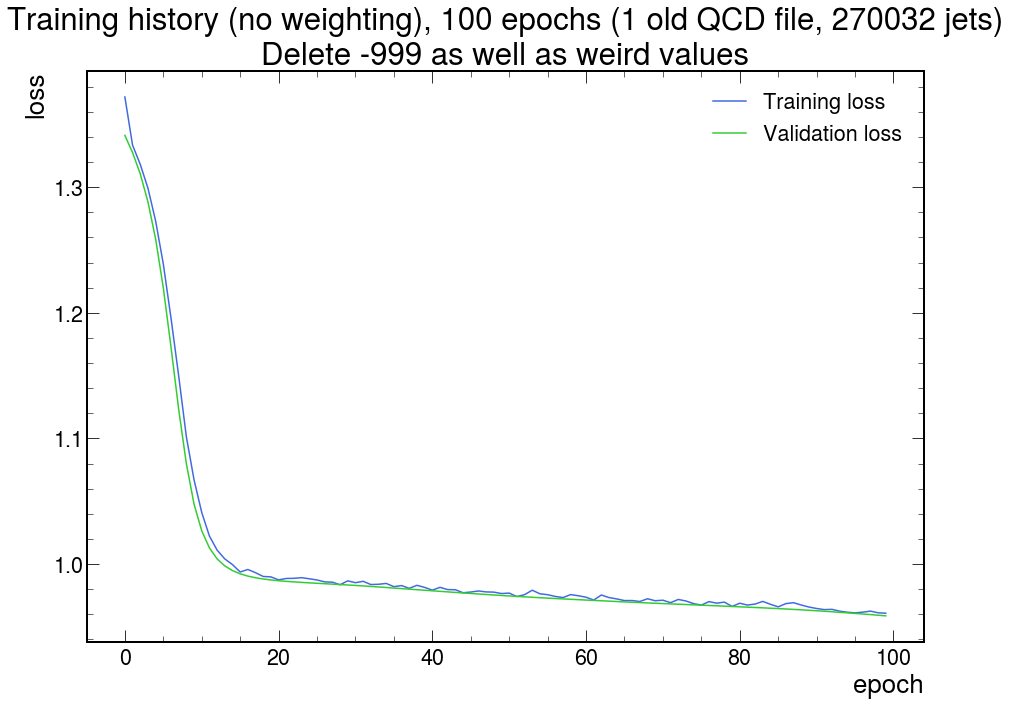

In [60]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_as_is'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (no weighting), {prev_epochs_0} epochs ({NUM_DATASETS} old QCD file, {total_n_train} jets)\nDelete -999 as well as weird values")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [61]:
#evaluate network on inputs
#model.to(device)
#test_inputs.cuda()
#test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs.float()).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [62]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [63]:
mostprob = torch.argmax(predsTensor, 1)

In [64]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[    0,  1467,     0,  2234],
       [    0,  2644,     0,  1507],
       [    0,   974,     0,  9538],
       [    0,   463,     0, 56182]])

In [65]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (no weighting) and DeepCSV outputs\n After 100 epochs, evaluated on 75009 jets')

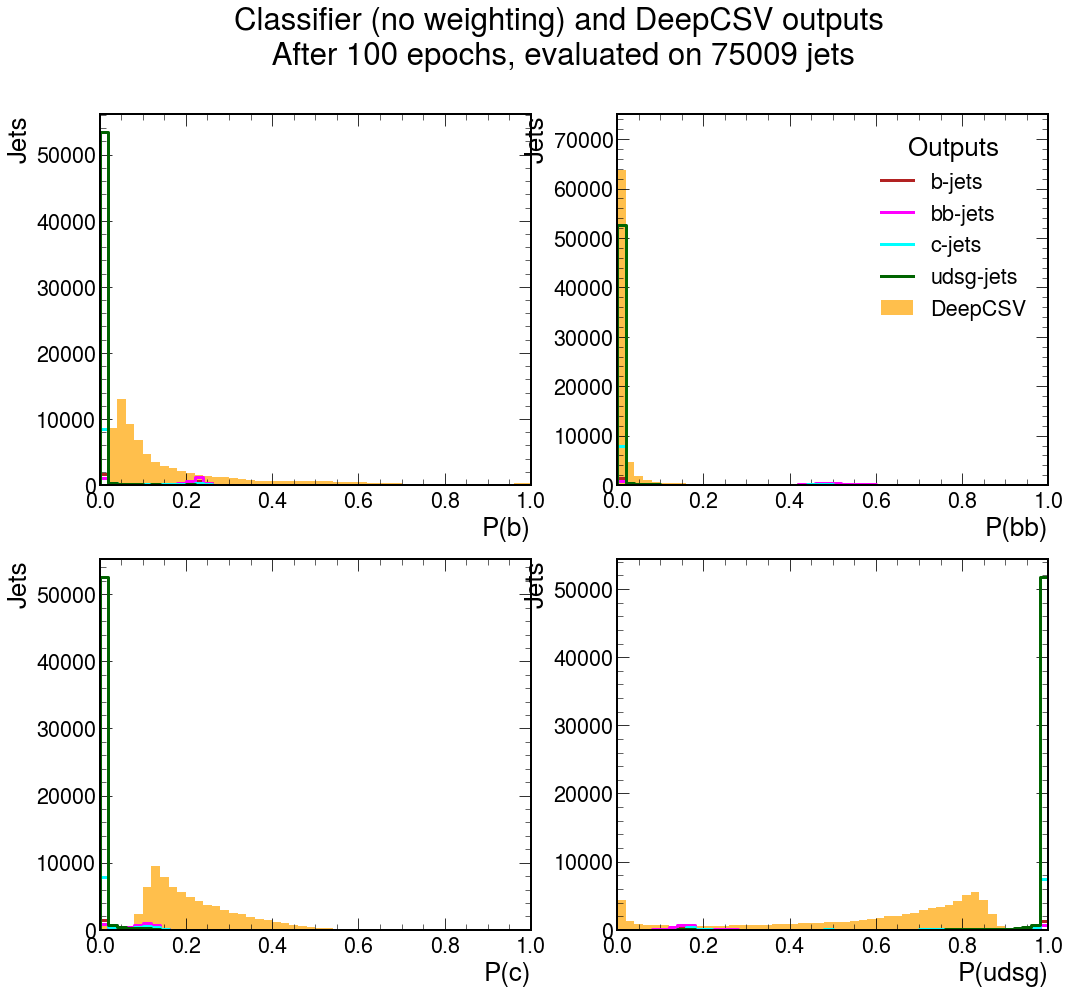

In [66]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (no weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.825127402464168
auc for bb-tagging: 0.9210201681249042
auc for c-tagging: 0.64809375816307
auc for udsg-tagging: 0.7954123822646015


22055

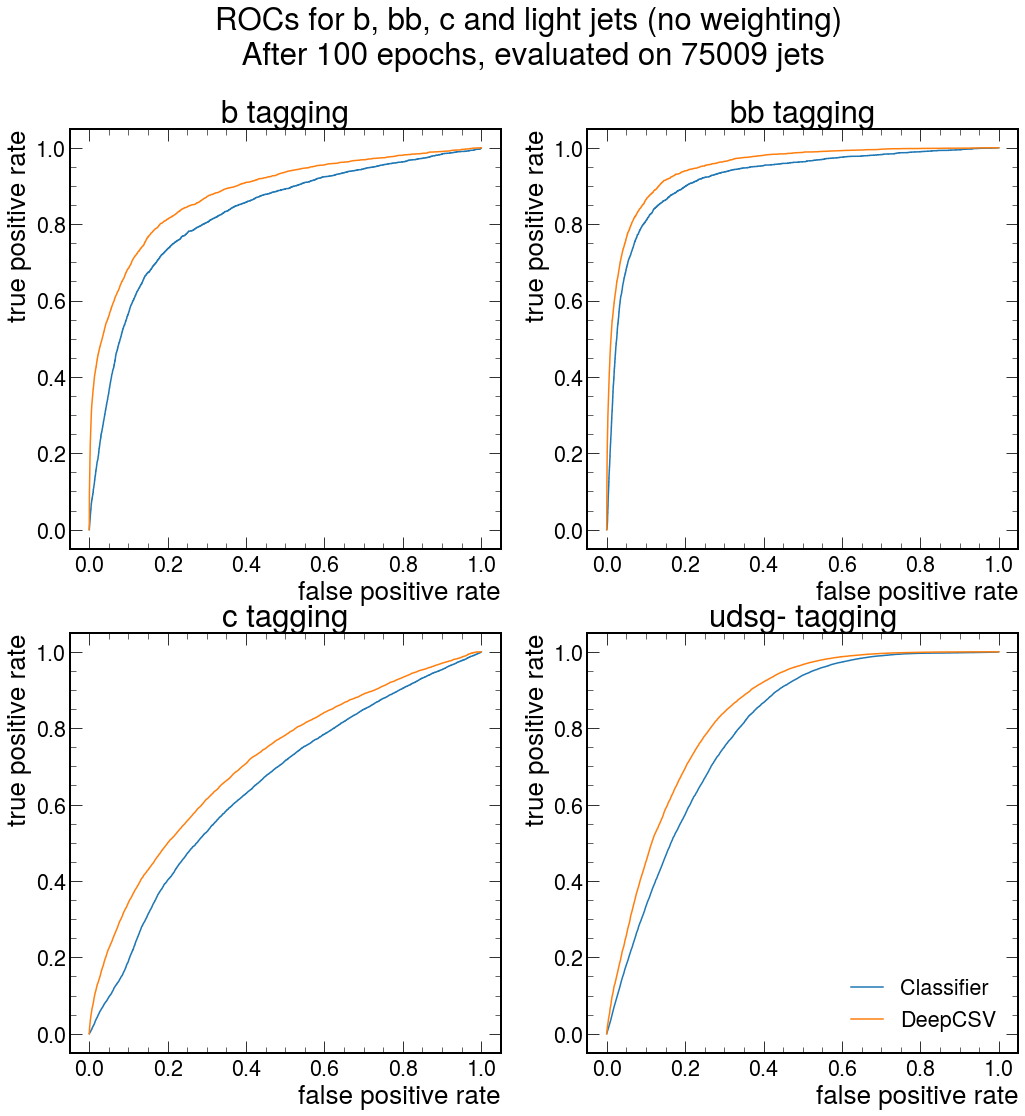

In [67]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (no weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

In [30]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_wrs'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 5000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.0001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        g['lr'] = lrate/(1+ep/10)
        #g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _wrs
starting to train the model after 0 epochs that were already done
learning rate for this script: 0.0001
batch size for this script: 5000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
270032 	training samples
30004 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time fo

## Plot loss

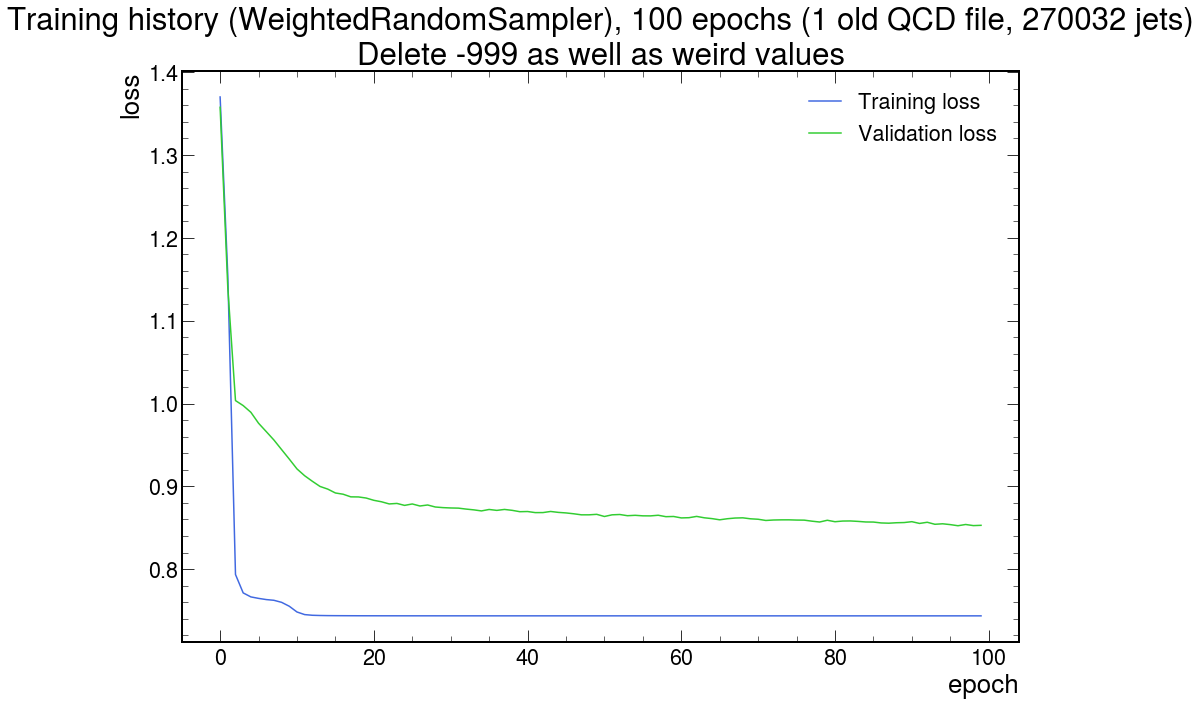

In [31]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_wrs'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (WeightedRandomSampler), {prev_epochs_0} epochs ({NUM_DATASETS} old QCD file, {total_n_train} jets)\nDelete -999 as well as weird values")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [32]:
#evaluate network on inputs
#model.to(device)
#test_inputs.cuda()
#test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs.float()).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [33]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [34]:
mostprob = torch.argmax(predsTensor, 1)

In [35]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[    0,  1560,   536,  1605],
       [    0,  1850,   311,  1990],
       [    0,  1195,  1934,  7383],
       [    0,  3123, 12100, 41422]])

In [36]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After 100 epochs, evaluated on 75009 jets')

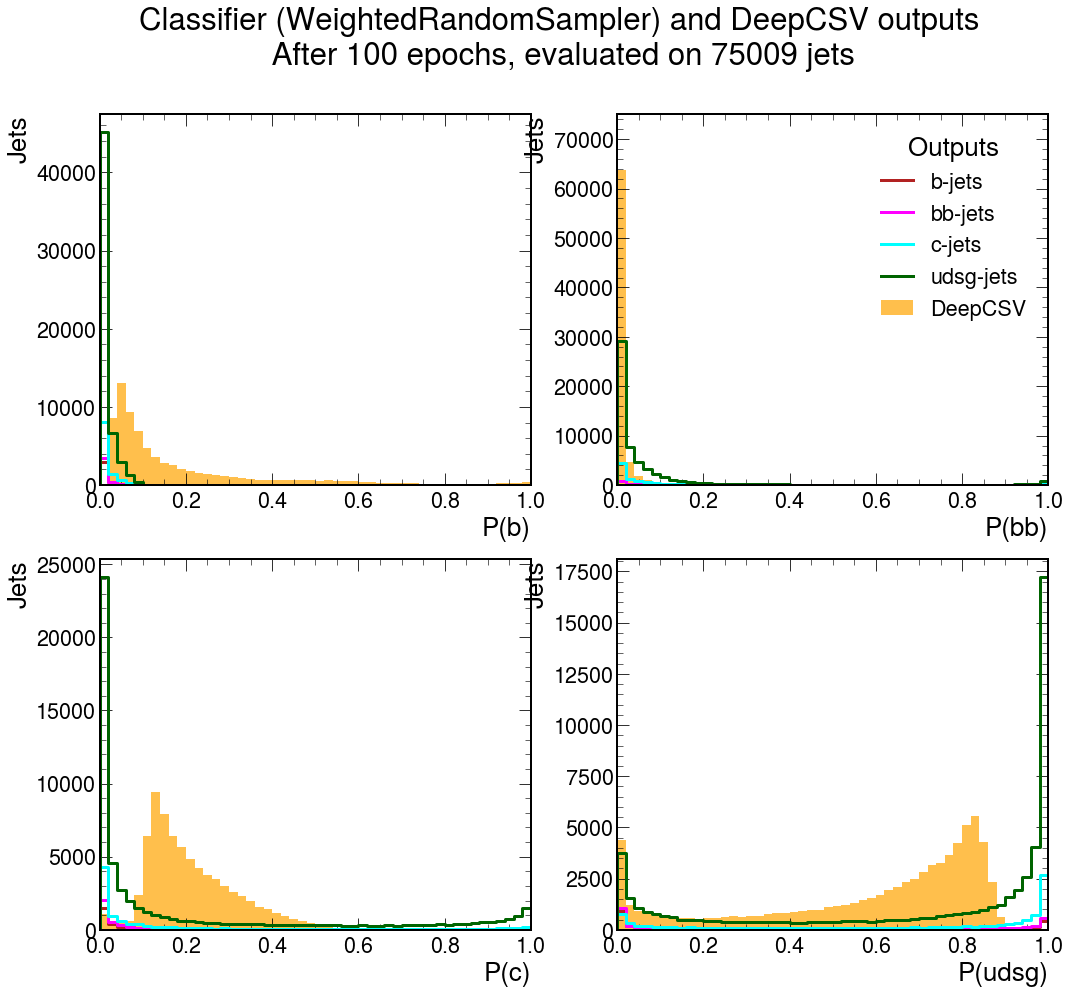

In [37]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.46277898259514155
auc for bb-tagging: 0.7517415030317828
auc for c-tagging: 0.5102751724685837
auc for udsg-tagging: 0.6005808140589997


22040

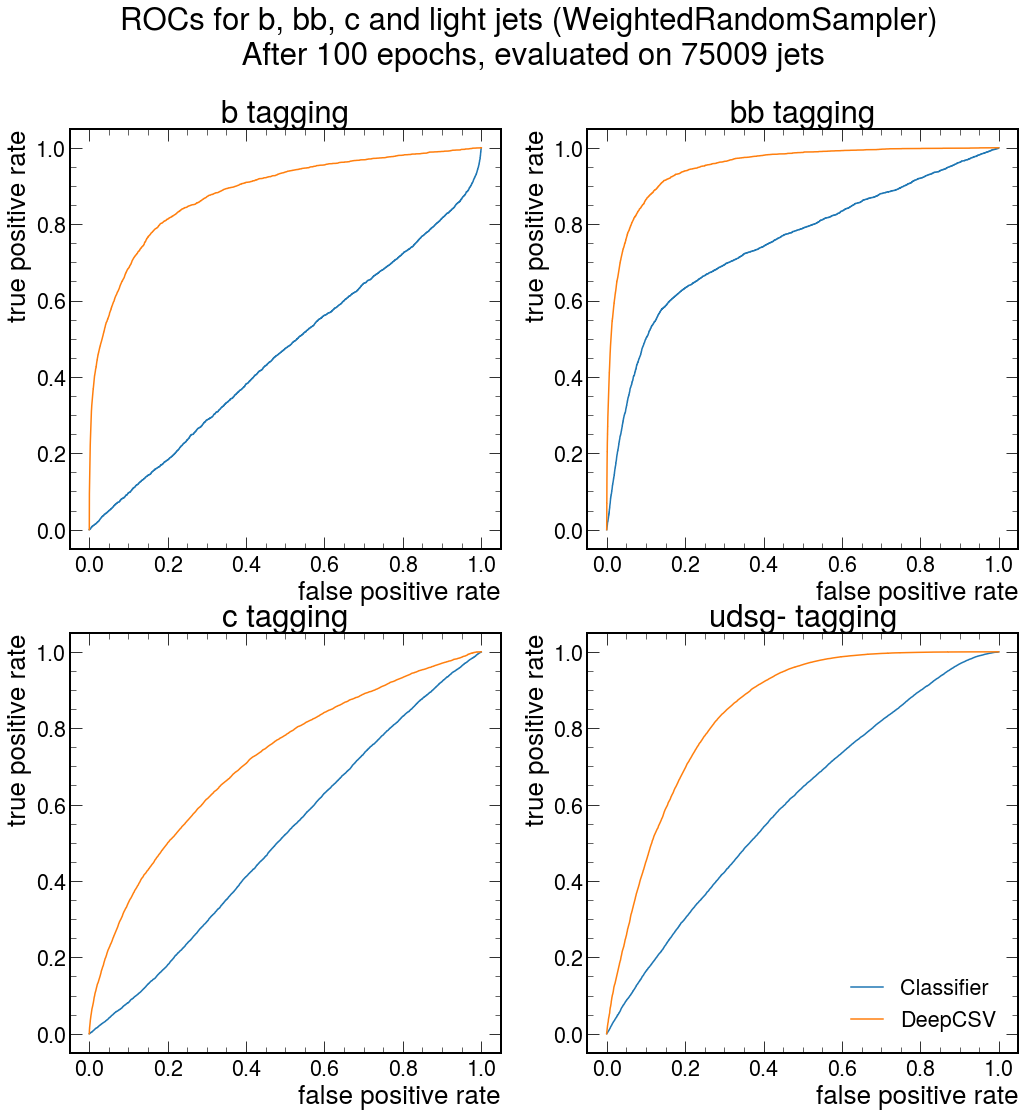

In [38]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (WeightedRandomSampler)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

In [39]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_new'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 10000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.0001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        #g['lr'] = lrate/(1+ep/10)
        g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _new
starting to train the model after 0 epochs that were already done
learning rate for this script: 0.0001
batch size for this script: 10000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
270032 	training samples
30004 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time f

## Plot loss

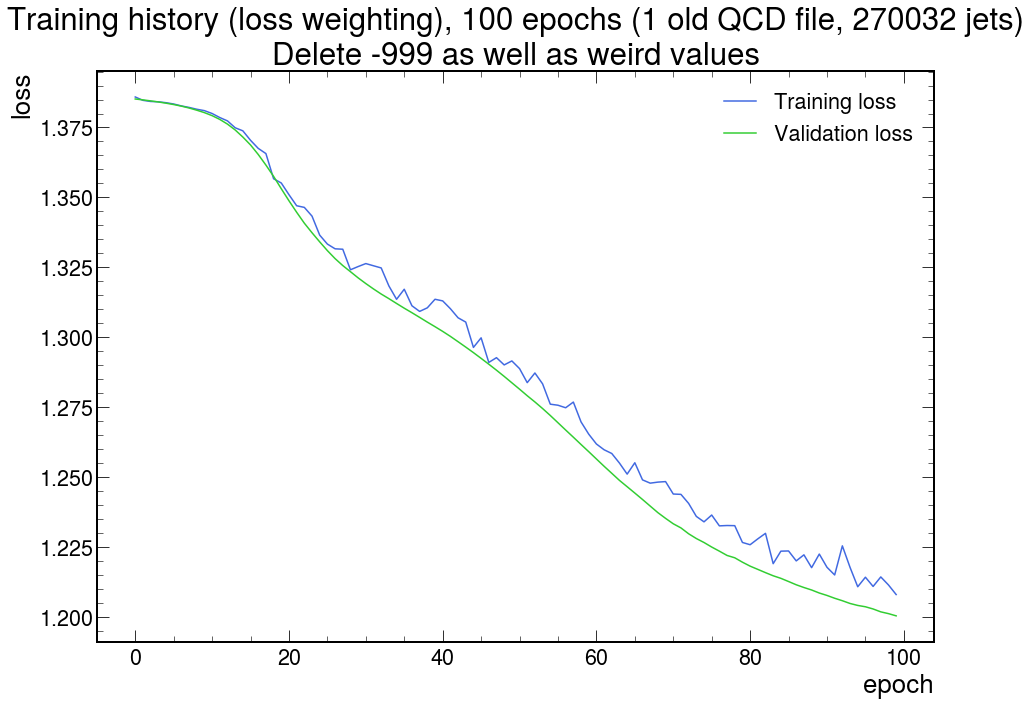

In [40]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_new'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (loss weighting), {prev_epochs_0} epochs ({NUM_DATASETS} old QCD file, {total_n_train} jets)\nDelete -999 as well as weird values")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [41]:
#evaluate network on inputs
#model.to(device)
#test_inputs.cuda()
#test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs.float()).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [42]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [43]:
mostprob = torch.argmax(predsTensor, 1)

In [44]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[ 1653,   882,   278,   888],
       [  827,  2877,   182,   265],
       [ 2207,  1307,  1163,  5835],
       [ 5040,  1500,  3784, 46321]])

In [45]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 100 epochs, evaluated on 75009 jets')

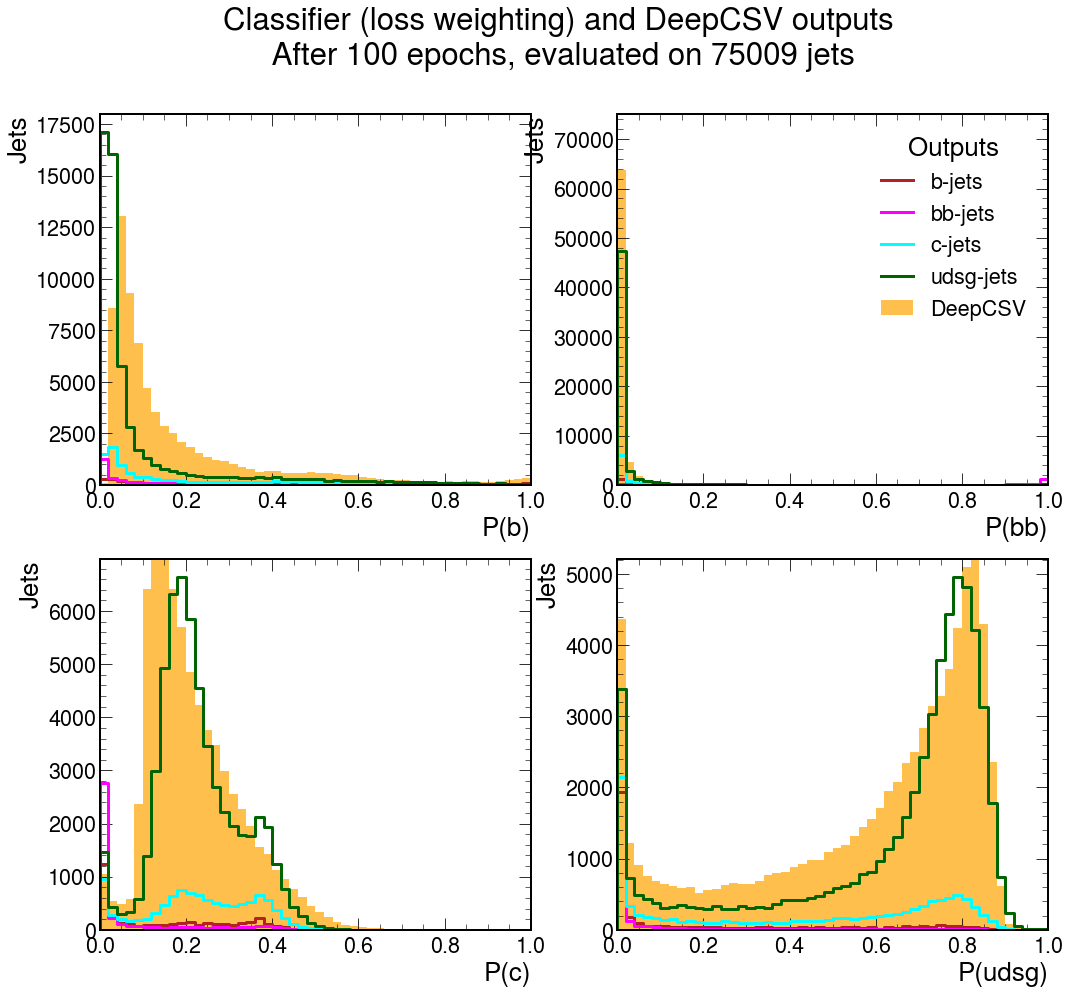

In [46]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.7747537305278795
auc for bb-tagging: 0.9320991085220445
auc for c-tagging: 0.5567782763732901
auc for udsg-tagging: 0.7845268129382077


22040

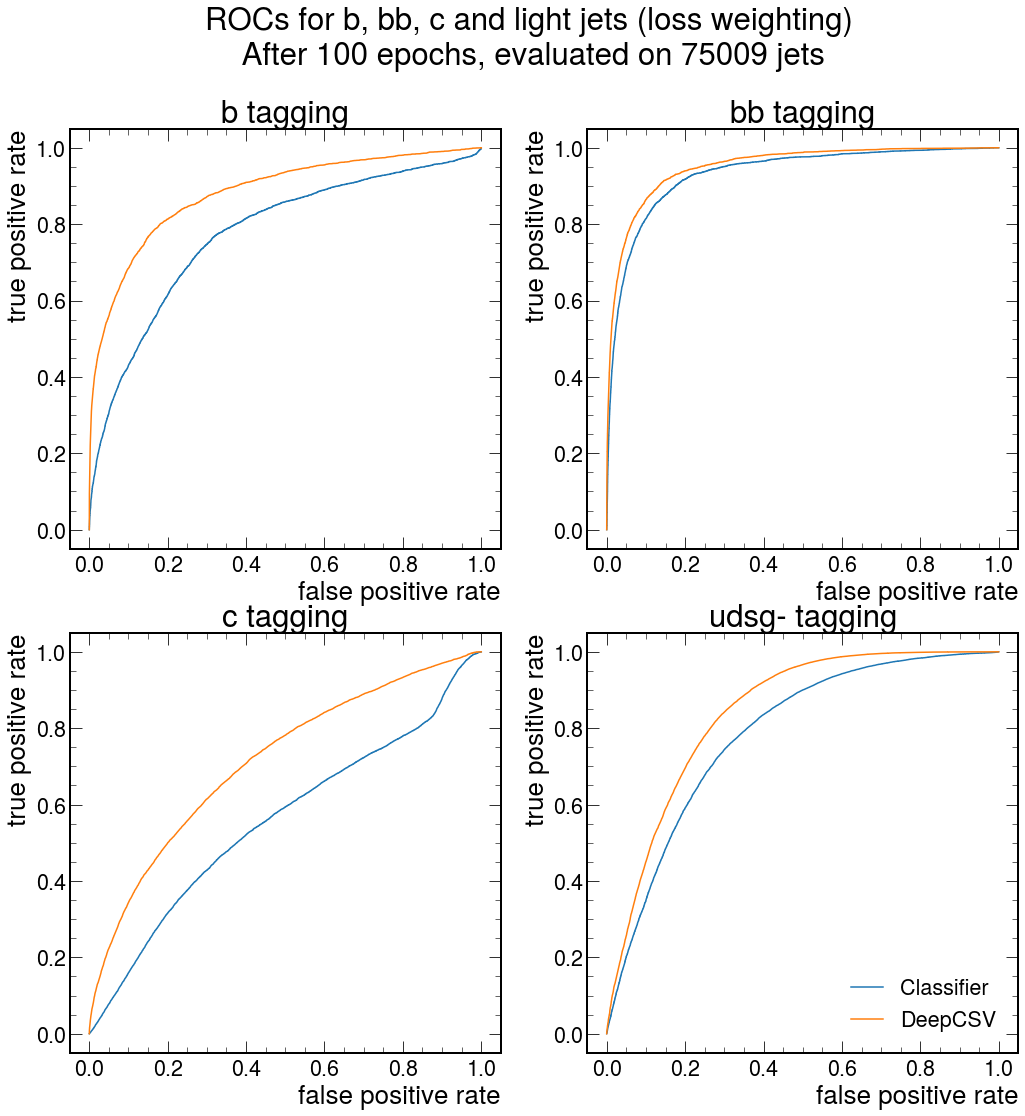

In [47]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (loss weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()

In [ ]:
start = time.time()




'''
parser = argparse.ArgumentParser(description="Setup for training")
parser.add_argument("files", type=int, help="Number of files for training")
parser.add_argument("prevep", type=int, help="Number of previously trained epochs")
parser.add_argument("addep", type=int, help="Number of additional epochs for this training")
parser.add_argument("wm", help="Weighting method")
args = parser.parse_args()
'''
NUM_DATASETS = 1
prev_epochs = 0
epochs = 100
weighting_method = '_new'




'''
    Weighting method:
        '_as_is'  :  apply no weighting factors at all
        ''        :  with factor 1 - relative frequency per flavour category
        '_new'    :  n_samples / (n_classes * n_class_count) per flavour category in loss function
        '_wrs'    :  using WeightedRandomSampler with n_samples / (n_classes * n_class_count)
'''
#weighting_method = '_as_is'    # this is now controlled by the parser above
print(f'weighting method: {weighting_method}')    

# Parameters for the training and validation    
bsize = 10000     # this might seem large, but for comparison: bsize of 250000 for 86M training inputs
lrate = 0.0001     # initial learning rate, only for first epoch
#prev_epochs = 0   # this is now controlled by the parser above

# Manually update the file path to the latest training job message
print(f'starting to train the model after {prev_epochs} epochs that were already done')
print(f'learning rate for this script: {lrate}')
print(f'batch size for this script: {bsize}')
    
#NUM_DATASETS = 229    # this is now controlled by the parser above
#NUM_DATASETS = 42
#NUM_DATASETS = 10    # just for testing

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"Setup: TT to Semileptonic samples, weighting method {weighting_method}, so far {prev_epochs} epochs done. Use lr={lrate} and bsize={bsize}.\n")


train_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
train_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/train_targets_%d.pt' % k for k in range(0,NUM_DATASETS)] 
val_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_inputs_%d.pt' % k for k in range(0,NUM_DATASETS)]
val_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/val_targets_%d.pt' % k for k in range(0,NUM_DATASETS)]    
'''


'''
# Old way to load validation samples
pre = time.time()


prepro_val_inputs = torch.cat(tuple(torch.load(vi).to(device) for vi in val_input_file_paths)).float()
print('prepro val inputs done')
prepro_val_targets = torch.cat(tuple(torch.load(vi).to(device) for vi in val_target_file_paths))
print('prepro val targets done')

post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
'''


##### LOAD TRAINING SAMPLES #####

pre = time.time()

#allin = ConcatDataset([TensorDataset(torch.load(train_input_file_paths[f]), torch.load(train_target_file_paths[f])) for f in range(NUM_DATASETS)])
allin = TensorDataset(train_inputs, train_targets)



post = time.time()
print(f"Time to load train: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")



##### LOAD VAL SAMPLES #####

pre = time.time()

#allval = ConcatDataset([TensorDataset(torch.load(val_input_file_paths[f]), torch.load(val_target_file_paths[f])) for f in range(NUM_DATASETS)])
allval = TensorDataset(val_inputs, val_targets)


post = time.time()
print(f"Time to load val: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")





pre = time.time()

if weighting_method == '_wrs':
    #weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    #samples_weights = weights[torch.concat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)])]
    #ts = torch.cat([torch.load(train_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy()
    ts = train_targets.numpy()
    class_weights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=ts)
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allin),
        replacement=True)
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    sampler = WeightedRandomSampler(
        weights=class_weights,
        num_samples=len(allval),
        replacement=True)
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, sampler=sampler, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
else:
    trainloader = torch.utils.data.DataLoader(allin, batch_size=bsize, shuffle=True, num_workers=0)
    post = time.time()
    print(f"Time to create trainloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")
    
    valloader = torch.utils.data.DataLoader(allval, batch_size=100000000, shuffle=False, num_workers=0)
    post = time.time()
    print(f"Time to create valloader: {np.floor((post-pre)/60)} min {np.ceil((post-pre)%60)} s")


total_len_train = len(trainloader)
total_n_train = len(trainloader.dataset)
print(total_n_train,'\ttraining samples')



total_len_val = len(valloader)
total_n_val = len(valloader.dataset)
print(total_n_val,'\tvalidation samples')


# The new method for validation inputs is needed because the total file size for validation is too big to fit on a single gpu (16GB) that is already occupied by the model / loss 
# computation graph etc..






model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))

'''
if prev_epochs > 0:
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
    #checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_10_epochs_v4_GPU_weighted_as_is.pt')
    model.load_state_dict(checkpoint["model_state_dict"])
'''
print(model)

'''
# In principle, one can use multiple gpu devices with DataParallel. However, in this particular case, the cons are that the data transfer takes longer, and loss / weights will be averaged
# when both results are merged. The model might be too simple to profit from this method. First tests took longer than with just one device, and the loss did not go down as fast.
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
'''
model.to(device)

# Choose the parameter for weighting in the loss function, according to the choice above
if weighting_method == '':
    # as calculated in dataset_info.ipynb
    allweights = [0.7158108642980718, 0.9962305696752469, 0.9099623138559123, 0.37799625217076893]   # not for this one
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
elif weighting_method == '_new':
    allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=train_targets.numpy())
    class_weights = torch.FloatTensor(allweights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = nn.CrossEntropyLoss()
    
    
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)


if prev_epochs > 0:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    '''
    # update the learning rate to the new one
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev run')
        g['lr'] = lrate
        print('lr: ', g['lr'], 'after update')
    '''

def new_learning_rate(ep):
    for g in optimizer.param_groups:
        print('lr: ', g['lr'], 'prev epoch')
        g['lr'] = lrate/(1+ep/10)
        #g['lr'] = 0.00001
        #print('lr: ', g['lr'], 'after update')
        
#The training algorithm

tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100

# epochs to be trained with the current script (on top of the prev_epochs)
#epochs = 1    # this is now controlled by the parser above
times = []

'''
with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
    log.write(f"{np.floor((tic-start)/60)} min {np.ceil((tic-start)%60)} s"+' Everything prepared for main training loop.\n')
'''



for e in range(epochs):
    times.append(time.time())
    if prev_epochs+e >= 1:
        new_learning_rate(prev_epochs+e)
    running_loss = 0
    model.train()
    for b, (i,j) in enumerate(trainloader):
        if e == 0 and b == 1:
            tb1 = time.time()
            print('first batch done')
            print(f"Time for first batch: {np.floor((tb1-times[0])/60)} min {((tb1-times[0])%60)} s")
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tb1-start)/60)} min {np.ceil((tb1-start)%60)} s"+' First batch done!\n')
            '''
        i = i.to(device, non_blocking=True)
        j = j.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(i.float())
        loss = criterion(output, j)
        del i
        del j
        gc.collect()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
        del output
        gc.collect()
    else:
        del loss
        gc.collect()
        if e == 0:
            tep1 = time.time()
            print('first training epoch done, now starting first evaluation')
            '''
            with open(f"/home/um106329/aisafety/new_march_21/models/logfile{weighting_method}_{NUM_DATASETS}_files_TT.txt", "a") as log:
                log.write(f"{np.floor((tep1-start)/60)} min {np.ceil((tep1-start)%60)} s"+' First training epoch done! Start first evaluation.\n')
            '''
        with torch.no_grad():
            model.eval()
            if e > 0:
                del vloss
                del val_output
                gc.collect()
            running_val_loss = 0
            for i,j in valloader:
                i = i.to(device, non_blocking=True)
                j = j.to(device, non_blocking=True)
                val_output = model(i.float())
                vloss = criterion(val_output, j)
                del i
                del j
                gc.collect()
                vloss = vloss.item()
                running_val_loss += vloss
            '''
            # Old method to calc validation loss
            val_output = model(prepro_val_inputs)
            val_loss = criterion(val_output, prepro_val_targets)
            '''
            val_loss_history.append(running_val_loss/total_len_val)
            
            

            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if running_val_loss < min_loss:
                min_loss = running_val_loss
                stale_epochs = 0
            else:
                stale_epochs += 1
            # e+1 to count from "1" instead of "0"
            print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}",end='\n')
        loss_history.append(running_loss/total_len_train)
        #if (e+1)%np.floor(epochs/10)==0:
        #    print(f"{(e+1)/epochs*100}% done. Epoch: {prev_epochs+e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {val_loss/total_len_val}")
            
        #torch.save({"epoch": prev_epochs+e, "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "loss": running_loss/total_len_train, "val_loss": running_val_loss/total_len_val}, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+(e + 1)}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT.pt')
toc = time.time()
#print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/total_len_train}\tValidation loss: {running_val_loss/total_len_val}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")
print(f"used {NUM_DATASETS} files, {prev_epochs+epochs} epochs, dropout 0.1 4x, learning rate {lrate}")


#torch.save(model, f'/home/um106329/aisafety/new_march_21/models/march2021_{prev_epochs+epochs}_epochs_v10_GPU_weighted{weighting_method}_{NUM_DATASETS}_datasets_TT_justModel.pt')


times.append(toc)
for p in range(epochs):
    print(f"Time for epoch {prev_epochs+p}: {np.floor((times[p+1]-times[p])/60)} min {((times[p+1]-times[p])%60)} s")
end = time.time()
print(f"Total time for whole script: {np.floor((end-start)/60)} min {np.ceil((end-start)%60)} s")



weighting method: _new
starting to train the model after 0 epochs that were already done
learning rate for this script: 0.0001
batch size for this script: 10000
Time to load train: 0.0 min 1.0 s
Time to load val: 0.0 min 1.0 s
Time to create trainloader: 0.0 min 1.0 s
Time to create valloader: 0.0 min 1.0 s
270032 	training samples
30004 	validation samples
Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)
first batch done
Time f

## Plot loss

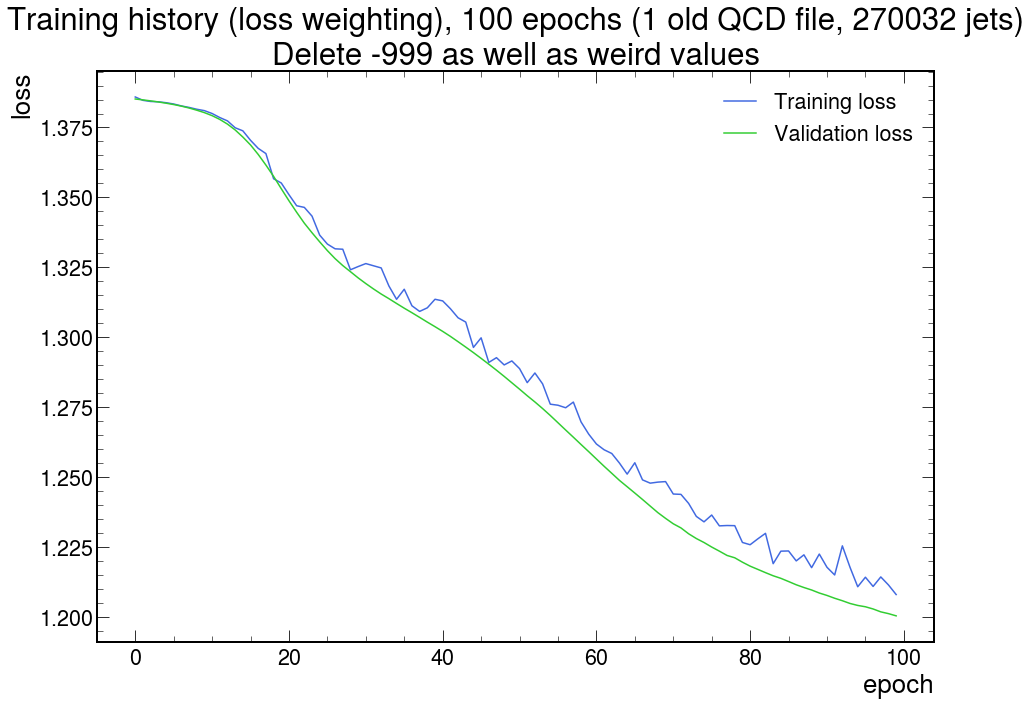

In [40]:
prev_epochs_0 = 100



NUM_DATASETS = 1


weighting_method_0 = '_new'

plt.figure(1,figsize=[15,10.5])
plt.plot(loss_history,color='royalblue')
plt.plot(val_loss_history,color='limegreen')
plt.title(f"Training history (loss weighting), {prev_epochs_0} epochs ({NUM_DATASETS} old QCD file, {total_n_train} jets)\nDelete -999 as well as weird values")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training loss','Validation loss'])

In [41]:
#evaluate network on inputs
#model.to(device)
#test_inputs.cuda()
#test_inputs = test_inputs.type(torch.cuda.FloatTensor)
print(type(test_inputs))
model.eval()
predsTensor = model(test_inputs.float()).detach()
predictions = predsTensor.cpu().numpy()
print('predictions done')

jetFlavour = test_targets+1

<class 'torch.Tensor'>
predictions done


In [42]:
np.unique(test_targets.numpy())

array([0, 1, 2, 3])

In [43]:
mostprob = torch.argmax(predsTensor, 1)

In [44]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets.cpu(), mostprob.cpu())
cfm

array([[ 1653,   882,   278,   888],
       [  827,  2877,   182,   265],
       [ 2207,  1307,  1163,  5835],
       [ 5040,  1500,  3784, 46321]])

In [45]:
len_test = len(test_inputs)

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 100 epochs, evaluated on 75009 jets')

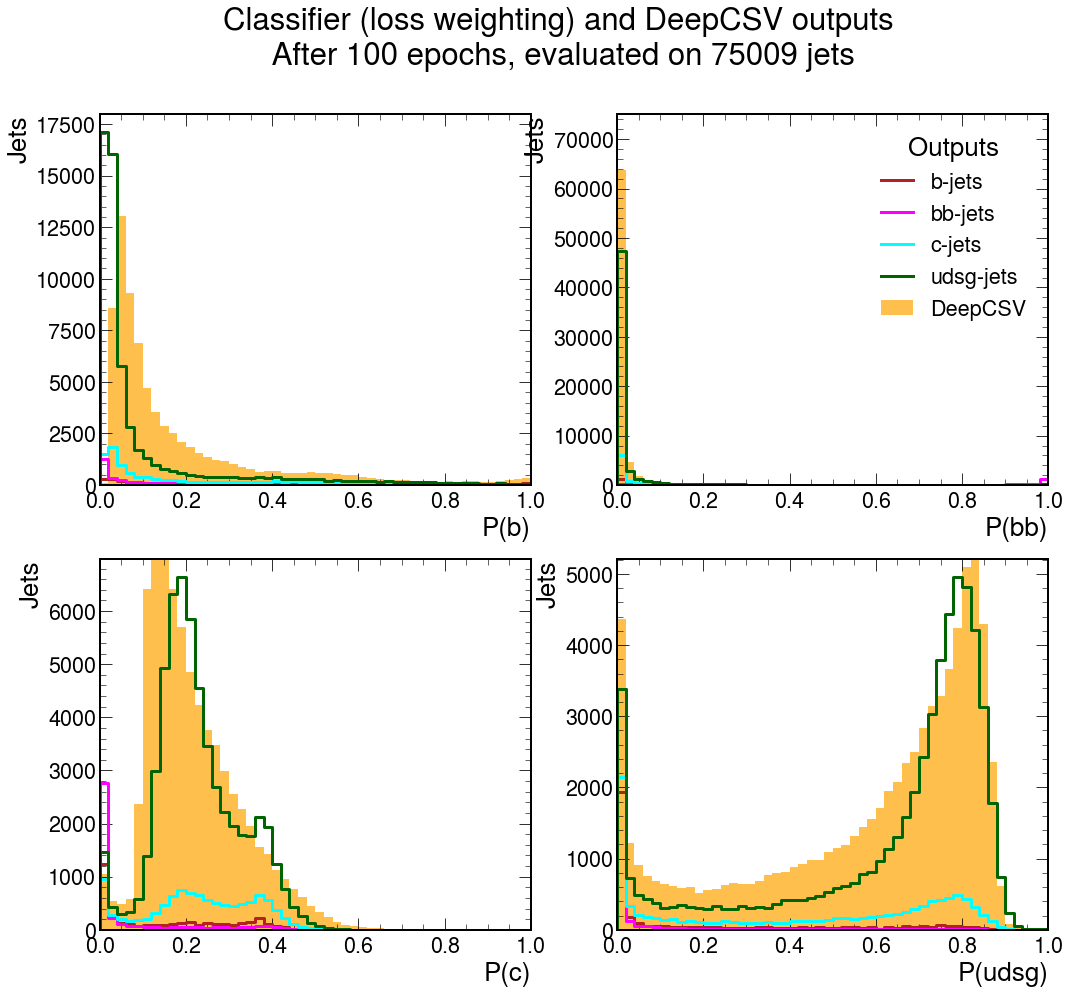

In [46]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.7747537305278795
auc for bb-tagging: 0.9320991085220445
auc for c-tagging: 0.5567782763732901
auc for udsg-tagging: 0.7845268129382077


22040

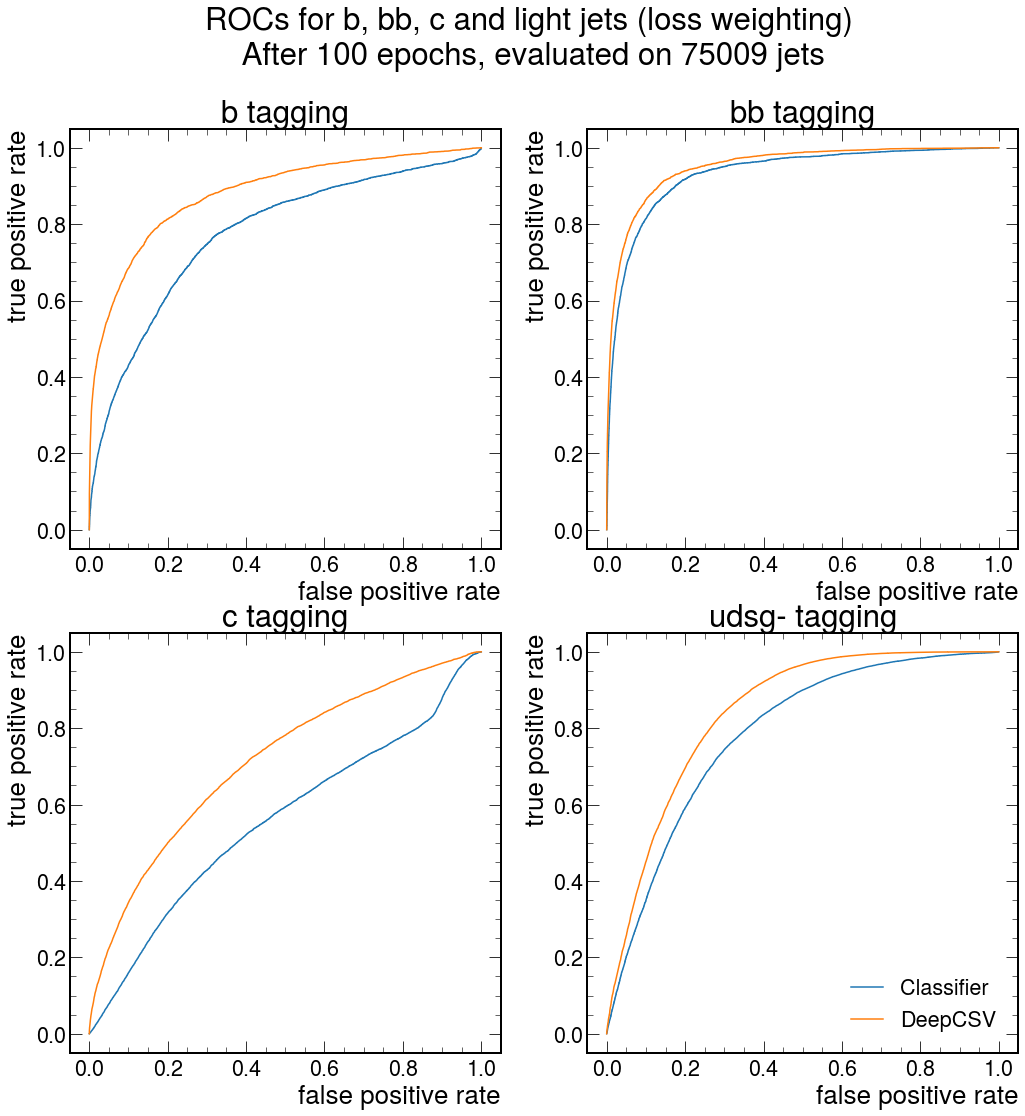

In [47]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (loss weighting)\n After {prev_epochs_0} epochs, evaluated on {len_test} jets')
gc.collect()